In [69]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [1]:
#Read the saved Vegetation Indices from the drive
ds_p1 = xr.open_dataset('/content/drive/MyDrive/Colab Notebooks/S2vi_14day_p1.nc')
ds_p2 = xr.open_dataset('/content/drive/MyDrive/Colab Notebooks/S2vi_14day_p2.nc')

In [4]:
#Select EVI to use for phenological metrics estimation and mask only EVI between 0.005 and 1
evi_p1 = ds_p1.EVI
evi_p2 = ds_p2.EVI

#Remove EVI less than 0.005 and more than 1 as they are likely noise or clouds
evi_p1 = evi_p1.where((evi_p1 >= 0.005) & (evi_p1 <= 1))
print("Min EVI:", evi_p1.min().item())
print("Max EVI:", evi_p1.max().item())

evi_p2 = evi_p2.where((evi_p2 >= 0.005) & (evi_p2 <= 1))
print("Min EVI:", evi_p2.min().item())
print("Max EVI:", evi_p2.max().item())

Min EVI: 0.0050868140533566475
Max EVI: 0.9936724901199341
Min EVI: 0.005157893057912588
Max EVI: 0.9984394311904907


In [5]:
#Extract the time values
time_p1 = evi_p1.time.values
time_p2 = evi_p2.time.values

In [7]:
# Function to extract two seasons from a 1D time series
def extract_phenology(ts):
    ts = np.array(ts)
    if np.isnan(ts).all():
        return np.full(6, np.nan)

    peaks, _ = find_peaks(ts, distance=3, prominence=0.02)
    if len(peaks) == 0:
        return np.full(6, np.nan)

    # Take 2 highest peaks
    peak_vals = ts[peaks]
    top_two = peaks[np.argsort(peak_vals)[-2:]]  # get top 2
    top_two.sort()

    out = []
    for peak in top_two:
        sos = peak
        while sos > 1 and ts[sos - 1] < ts[sos]:
            sos -= 1
        eos = peak
        while eos < len(ts) - 2 and ts[eos + 1] < ts[eos]:
            eos += 1
        out.extend([sos, peak, eos])

    # If only one season
    if len(out) < 6:
        out.extend([np.nan] * (6 - len(out)))
    return out

In [45]:
#Define a random target pixel: plot_106 in SOC data
target_lon = 37.468
target_lat = 0.1737

# Find nearest index in coordinate arrays
lon_idx = np.abs(evi_p1.lon.values - target_lon).argmin()
lat_idx = np.abs(evi_p1.lat.values - target_lat).argmin()

In [46]:
# Apply to the defined sample pixel first
sample_ts_p1 = evi_p1[:, lat_idx, lon_idx].values
phenology_sample_p1 = extract_phenology(sample_ts_p1)

sample_ts_p2 = evi_p2[:, lat_idx, lon_idx].values
phenology_sample_p2 = extract_phenology(sample_ts_p2)

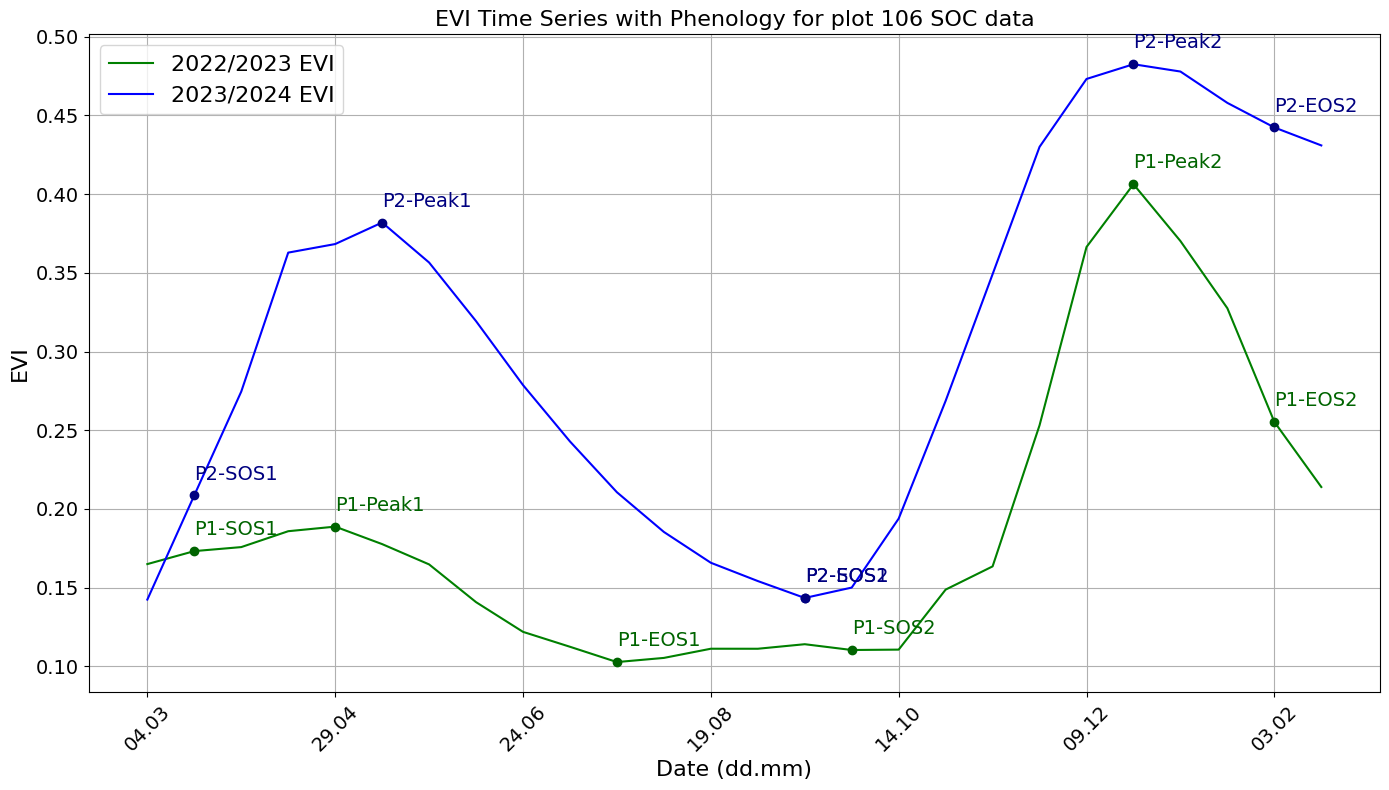

In [62]:
# Plot the phenological metrics for the sampled location
# Extract time values and convert to dd.mm format
time_labels_p1 = pd.to_datetime(evi_p1.time.values).strftime('%d.%m')
time_labels_p2 = pd.to_datetime(evi_p2.time.values).strftime('%d.%m')

# Time index for x-axis
time_index_p1 = np.arange(len(sample_ts_p1))
time_index_p2 = np.arange(len(sample_ts_p2))

plt.figure(figsize=(14, 8))

# Plot EVI time series
plt.plot(time_index_p1, sample_ts_p1, label='2022/2023 EVI', color='green')
plt.plot(time_index_p2, sample_ts_p2, label='2023/2024 EVI', color='blue')

# Function to plot phenology points
def plot_pheno_points(ts, pheno, color, label_prefix):
    labels = ['SOS1', 'Peak1', 'EOS1', 'SOS2', 'Peak2', 'EOS2']
    for i, name in enumerate(labels):
        idx = int(pheno[i])
        if not np.isnan(pheno[i]) and 0 <= idx < len(ts):
            plt.plot(idx, ts[idx], marker='o', color=color)
            plt.text(idx, ts[idx] + 0.01, f'{label_prefix}-{name}', color=color, fontsize=14)

# Add phenology markers
plot_pheno_points(sample_ts_p1, phenology_sample_p1, color='darkgreen', label_prefix='P1')
plot_pheno_points(sample_ts_p2, phenology_sample_p2, color='navy', label_prefix='P2')

# Improve x-axis with dd.mm labels
plt.xticks(time_index_p1[::4], time_labels_p1[::4], rotation=45,fontsize=14)  # Plot every 4th label for clarity
plt.yticks(fontsize=14)

plt.xlabel("Date (dd.mm)",fontsize=16)
plt.ylabel("EVI",fontsize=16)
plt.title("EVI Time Series with Phenology for plot 106 SOC data",fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("evi_phenology_sample.png", dpi=300, bbox_inches='tight')
plt.show()


**This part spatially apply the phenology on the whole study extent**

In [63]:
from joblib import Parallel, delayed

In [64]:
# Convert to numpy (this loads all into memory!)
evi_np_p1 = evi_p1.values  # shape: (time, lon, lat)
evi_np_p2 = evi_p2.values  # shape: (time, lon, lat)

In [65]:
# To spatially apply to full extent
def process_pixel(evi_array, i, j):
    ts = evi_array[:, i, j]
    return extract_phenology(ts)

# Apply to Period 1
results_p1 = Parallel(n_jobs=-1)(
    delayed(process_pixel)(evi_np_p1, i, j)
    for i in range(evi_np_p1.shape[1])
    for j in range(evi_np_p1.shape[2])
)

# Apply to Period 2
results_p2 = Parallel(n_jobs=-1)(
    delayed(process_pixel)(evi_np_p2, i, j)
    for i in range(evi_np_p2.shape[1])
    for j in range(evi_np_p2.shape[2])
)

# Reshape back to 3D: (rows, cols, 6 phenology metrics)
pheno_array_p1 = np.array(results_p1).reshape(evi_np_p1.shape[1], evi_np_p1.shape[2], 6)
pheno_array_p2 = np.array(results_p2).reshape(evi_np_p2.shape[1], evi_np_p2.shape[2], 6)


In [75]:
# Convert time steps to pandas datetime (time values in evi_p1)
time_vals_p1 = pd.to_datetime(evi_p1.time.values)
time_vals_p2 = pd.to_datetime(evi_p2.time.values)  # Assuming similar time structure for second period

# Now convert the result_array of indices to dates for both periods
result_dates_p1 = np.full_like(pheno_array_p1, np.datetime64("NaT"), dtype='datetime64[ns]')
result_dates_p2 = np.full_like(pheno_array_p2, np.datetime64("NaT"), dtype='datetime64[ns]')

# Ensure valid indices before casting
def convert_to_dates(result_array, time_vals):
    result_dates = np.full_like(result_array, np.datetime64("NaT"), dtype='datetime64[ns]')
    for idx in range(result_array.shape[2]):  # Loop over all phenology metrics (6 in total)
        # Get the indices of valid data (avoid NaN values)
        valid_mask = ~np.isnan(result_array[:, :, idx])
        if np.any(valid_mask):  # Proceed if there are valid values
            # Safely convert indices to integer and map to corresponding time values
            inds = result_array[:, :, idx].astype(int)
            result_dates[valid_mask, idx] = time_vals[inds[valid_mask]]
    return result_dates

# Convert the result arrays for both periods
result_dates_p1 = convert_to_dates(pheno_array_p1, time_vals_p1)
result_dates_p2 = convert_to_dates(pheno_array_p2, time_vals_p2)

<ipython-input-75-804b43729f35>:17: RuntimeWarning: invalid value encountered in cast
  inds = result_array[:, :, idx].astype(int)


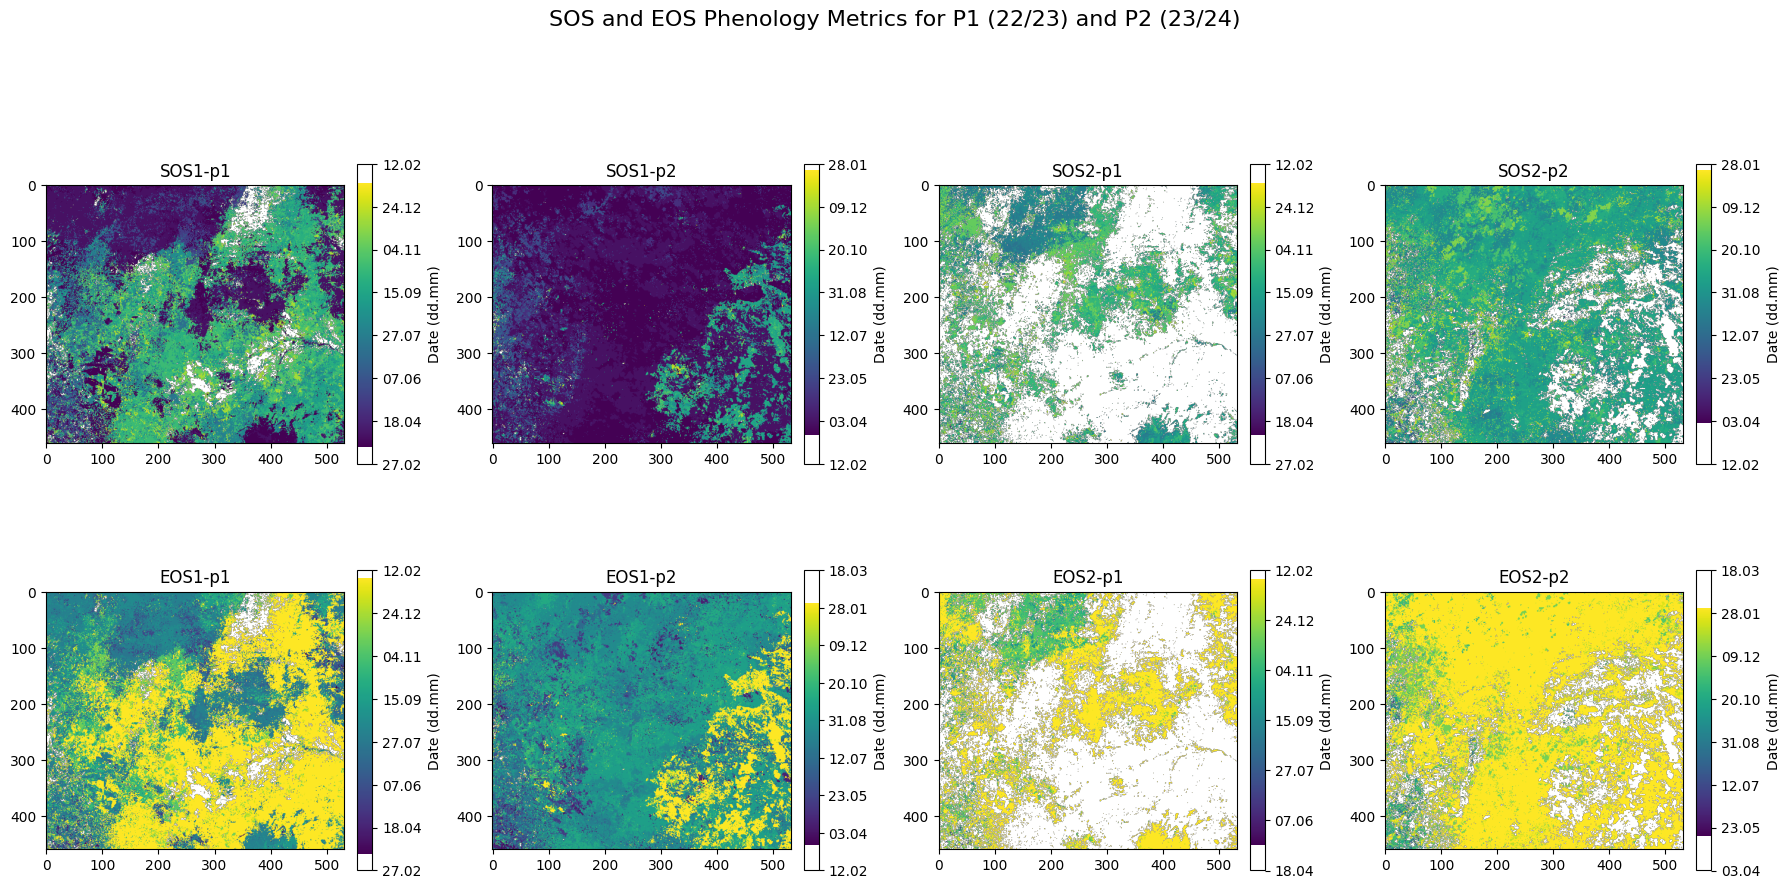

In [83]:
# Set up subplot layout
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle("SOS and EOS Phenology Metrics for P1 (22/23) and P2 (23/24)", fontsize=16)

# Titles and correct index mapping for each subplot
subplot_info = [
    ("SOS1", "p1", 0), ("SOS1", "p2", 0),
    ("SOS2", "p1", 3), ("SOS2", "p2", 3),
    ("EOS1", "p1", 2), ("EOS1", "p2", 2),
    ("EOS2", "p1", 5), ("EOS2", "p2", 5),
]

for ax, (stage, period, idx) in zip(axes.flat, subplot_info):
    # Get the appropriate date layer
    if period == 'p1':
        date_layer = result_dates_p1[:, :, idx]
    else:
        date_layer = result_dates_p2[:, :, idx]

    # Flatten, convert to float date numbers for imshow
    flat_dates = pd.to_datetime(date_layer.flatten())
    valid_mask = ~pd.isnull(flat_dates)

    date_nums = np.full(flat_dates.shape, np.nan)
    date_nums[valid_mask] = mdates.date2num(flat_dates[valid_mask])
    date_num_reshaped = date_nums.reshape(date_layer.shape)

    # Plot
    im = ax.imshow(date_num_reshaped, cmap='viridis')
    ax.set_title(f"{stage}-{period}")

    # Colorbar with dd.mm formatting
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ticks = cbar.get_ticks()
    tick_labels = [mdates.num2date(tick).strftime('%d.%m') for tick in ticks]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(tick_labels)
    cbar.set_label("Date (dd.mm)", fontsize=10)

# Final layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("evi_phenology_studyExtent.png", dpi=300, bbox_inches='tight')
plt.show()


This code calculates the productivity of both periods and computes the differences

In [86]:
#Calculate the productivity for each season individually
# First extract raw float SOS/EOS values (with NaNs preserved)
sos1_raw_p1 = pheno_array_p1[:, :, 0]
eos1_raw_p1 = pheno_array_p1[:, :, 2]
sos2_raw_p1 = pheno_array_p1[:, :, 3]
eos2_raw_p1 = pheno_array_p1[:, :, 5]

sos1_raw_p2 = pheno_array_p2[:, :, 0]
eos1_raw_p2 = pheno_array_p2[:, :, 2]
sos2_raw_p2 = pheno_array_p2[:, :, 3]
eos2_raw_p2 = pheno_array_p2[:, :, 5]

# Mask invalid (still in float form)
invalid1_p1 = np.isnan(sos1_raw_p1) | np.isnan(eos1_raw_p1)
invalid2_p1 = np.isnan(sos2_raw_p1) | np.isnan(eos2_raw_p1)

invalid1_p2 = np.isnan(sos1_raw_p2) | np.isnan(eos1_raw_p2)
invalid2_p2 = np.isnan(sos2_raw_p2) | np.isnan(eos2_raw_p2)

# Convert only valid SOS/EOS to integers
sos1_p1 = np.where(invalid1_p1, -1, sos1_raw_p1).astype(np.int32)
eos1_p1 = np.where(invalid1_p1, -1, eos1_raw_p1).astype(np.int32)
sos2_p1 = np.where(invalid2_p1, -1, sos2_raw_p1).astype(np.int32)
eos2_p1 = np.where(invalid2_p1, -1, eos2_raw_p1).astype(np.int32)

sos1_p2 = np.where(invalid1_p2, -1, sos1_raw_p2).astype(np.int32)
eos1_p2 = np.where(invalid1_p2, -1, eos1_raw_p2).astype(np.int32)
sos2_p2 = np.where(invalid2_p2, -1, sos2_raw_p2).astype(np.int32)
eos2_p2 = np.where(invalid2_p2, -1, eos2_raw_p2).astype(np.int32)

# Prepare output arrays
prod_S1_P1 = np.full_like(sos1_raw_p1, np.nan, dtype=np.float32)
prod_S2_P1 = np.full_like(sos2_raw_p1, np.nan, dtype=np.float32)

prod_S1_P2 = np.full_like(sos1_raw_p2, np.nan, dtype=np.float32)
prod_S2_P2 = np.full_like(sos2_raw_p2, np.nan, dtype=np.float32)

# Loop through time and sum valid EVI values
for t in range(evi_np_p1.shape[0]):
    mask1_p1 = (sos1_p1 <= t) & (eos1_p1 >= t) & ~invalid1_p1
    prod_S1_P1[mask1_p1] = np.nan_to_num(prod_S1_P1[mask1_p1]) + evi_np_p1[t][mask1_p1]

    mask2_p1 = (sos2_p1 <= t) & (eos2_p1 >= t) & ~invalid2_p1
    prod_S2_P1[mask2_p1] = np.nan_to_num(prod_S2_P1[mask2_p1]) + evi_np_p1[t][mask2_p1]

for t in range(evi_np_p1.shape[0]):
    mask1_p2 = (sos1_p2 <= t) & (eos1_p2 >= t) & ~invalid1_p2
    prod_S1_P2[mask1_p2] = np.nan_to_num(prod_S1_P2[mask1_p2]) + evi_np_p2[t][mask1_p2]

    mask2_p2 = (sos2_p2 <= t) & (eos2_p2 >= t) & ~invalid2_p2
    prod_S2_P2[mask2_p2] = np.nan_to_num(prod_S2_P2[mask2_p2]) + evi_np_p2[t][mask2_p2]


In [93]:
prod_S1_da_P1 =  xr.DataArray(prod_S1_P1, coords=[evi_p1.lon, evi_p1.lat], dims=["lon", "lat"])
prod_S2_da_P1 =  xr.DataArray(prod_S2_P1, coords=[evi_p1.lon, evi_p1.lat], dims=["lon", "lat"])

prod_S1_da_P2 =  xr.DataArray(prod_S1_P2, coords=[evi_p2.lon, evi_p2.lat], dims=["lon", "lat"])
prod_S2_da_P2 =  xr.DataArray(prod_S2_P2, coords=[evi_p2.lon, evi_p2.lat], dims=["lon", "lat"])

prod_diff_S1 = prod_S1_da_P1 - prod_S1_da_P2
prod_diff_S2 = prod_S2_da_P1 - prod_S2_da_P2

In [101]:
 #Create figure with 2 rows x 3 columns
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), subplot_kw={'projection': None})

# Flatten the axs array for easy indexing
axs = axs.flatten()

# Titles for subplots
titles = [
    "Season 1 - 2022/20223", "Season 1 - 2023/20224", "Diff Season 1 (22/23 - 23/24)",
    "Season 2 - 2022/20223", "Season 2 - 2023/20224", "Diff Season 2 (22/23 - 23/24)"
]

# Data arrays to plot
maps = [
    prod_S1_da_P1, prod_S1_da_P2,prod_diff_S1,
    prod_S2_da_P1, prod_S2_da_P2, prod_diff_S2
]

# Set shared color scale for difference maps
vmin_diff = min(prod_diff_S1.min().item(), prod_diff_S2.min().item())
vmax_diff = max(prod_diff_S1.max().item(), prod_diff_S2.max().item())
vlim = max(abs(vmin_diff), abs(vmax_diff))

# Plot each map
for i in range(6):
    im = maps[i].plot(ax=axs[i], cmap="YlGn", add_colorbar=True)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("Longitude")
    axs[i].set_ylabel("Latitude")

plt.tight_layout()
plt.savefig("evi_productivity_studyExtent.png", dpi=300, bbox_inches='tight')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [99]:
### Summary statistic for the productivity
# Create a dictionary of your maps
data_arrays = {
    "S1_P1": prod_S1_da_P1,
    "S1_P2": prod_S1_da_P2,
    "Diff_S1": prod_diff_S1,
    "S2_P1": prod_S2_da_P1,
    "S2_P2": prod_S2_da_P2,
    "Diff_S2": prod_diff_S2,
}

# Compute summary statistics for each map
summary_stats = {}
for name, da in data_arrays.items():
    stats = {
        "mean": float(da.mean().item()),
        "median": float(da.median().item()),
        "min": float(da.min().item()),
        "max": float(da.max().item()),
        "std": float(da.std().item())
    }
    summary_stats[name] = stats

# Convert to a pandas DataFrame
summary_df = pd.DataFrame(summary_stats).T
print(summary_df)

             mean    median       min        max       std
S1_P1    1.759456  1.573116  0.053765  10.593328  0.892368
S1_P2    2.733092  2.582295  0.054202  11.393062  1.225004
Diff_S1 -1.041358 -1.027450 -8.106720   6.752118  1.176628
S2_P1    1.917019  1.758020  0.062758   8.844795  0.864584
S2_P2    3.044096  3.099189  0.069902   8.838719  1.011838
Diff_S2 -1.396246 -1.603145 -6.523467   5.210443  1.308192
